### Importing the required libaries 

In [ ]:
import psycopg2 as pg
import gmplot 
import pandas as pd
import numpy as np
import gc
from IPython.display import display, HTML
import warnings
warnings.filterwarnings('ignore')
import time
import copy
import getpass
import plotly.express as px

In [2]:
start_time = time.time()
display(HTML("<style>:root { --jp-notebook-max-width: 100% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', lambda x: '%.2f' % x)

## Making the connection between the Postgres Server and Notebook

In [9]:
yb_host = 'localhost'
yb_port = '5432'
yb_db = 'jyoti_dp'
def yb_conn(db_host, db_name, db_port):
 user_name = input('Username:')
 pass_word = getpass.getpass('Password:')
 try:
     connection = pg.connect(
         host=db_host
         , database = db_name
         , user = user_name
         , password = pass_word
         , port = db_port)
     print('connection successful')
     return connection
 except Exception as e:
     print('connection failed')
     print(e)
     return None

In [32]:
connection = yb_conn(yb_host, yb_db, yb_port)


Username: my_user
Password: ········


connection successful


## Line Plot UDF to see the demand variation between dates at each hour

In [69]:
def line_plot(plotting_df):
    # Plot
    fig = px.line(plotting_df, x='date_hour_combined', y='distinct_vessels', title='Vessel Demand Over Time',
          hover_data={'date_hour_combined': '|%Y-%m-%d %H:%M:%S', 'distinct_vessels': True},
          markers=True)
    
    # Customizing layout
    fig.update_layout(
        title_font_color="navy",
        title_font_family="Calibri",
        title_font_size=24,
        xaxis_title="Date and Hour",
        yaxis_title="Number of Unique Vessels",
        xaxis=dict(
            title_font_family="Calibri",
            title_font_color="black",
            title_font_size=18,
            tickfont=dict(family="Calibri", size=14, color="black"),
            showgrid=True,
            gridcolor="lightgray"
        ),
        yaxis=dict(
            title_font_family="Calibri",
            title_font_color="black",
            title_font_size=18,
            tickfont=dict(family="Calibri", size=14, color="black"),
            showgrid=True,
            gridcolor="lightgray"
        ),
        legend=dict(
            title="Legend",
            title_font_family="Calibri",
            title_font_size=16,
            font=dict(family="Calibri", size=14, color="black"),
            bgcolor="rgba(255, 255, 255, 0.5)",
            bordercolor="black",
            borderwidth=1
        ),
       # plot_bgcolor='rgba(0,0,0,0)' , # Make plot background fully transparent
        hoverlabel=dict(
            bgcolor="white",  # Set background color of hover label
            font=dict(family="Calibri", size=15, color="black"))  # Set font properties of hover label
    )
    
    # Customizing marker properties
    fig.update_traces(marker=dict(size=6, color='cornflowerblue', symbol='circle'))
    
    fig.show()


## Calculating Bounding Box and Filtering the samples for observing the demand between 1st Jan to 2nd Jan'20

### Computing Bounding Box Axes

In [14]:
def calculate_bounding_box(latitude, longitude, height, width):
    # Calculate half height and width
    half_height = height / 2
    half_width = width / 2
    
    # Calculate bounding box coordinates
    min_lat = latitude - half_height
    max_lat = latitude + half_height
    min_lng = longitude - half_width
    max_lng = longitude + half_width
    
    return min_lat, max_lat, min_lng, max_lng

### Plotting bounding box and sampling down the vessels records

In [56]:
def bounding_box_plot(port_code,height,width,ports_data,vessels_data):
    #Fetching the lon and lat coordinates of Long Beach Port
    lgb_lon=ports_data.loc[ports_data['un_locode']==port_code,'longitude'].values[0]
    lgb_lat=ports_data.loc[ports_data['un_locode']==port_code,'latitude'].values[0]
    # Calculate bounding box
    min_lat, max_lat, min_lng, max_lng = calculate_bounding_box(lgb_lat, lgb_lon, height, width)
    # Initialize the map with the first coordinate
    gmap = gmplot.GoogleMapPlotter(lgb_lat, lgb_lon, 19)
    gmap.marker(lgb_lat, lgb_lon, color='darkgreen',label='US LGB') 

    # Plot the bounding box
    bounding_box_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
    bounding_box_lngs = [min_lng, max_lng, max_lng, min_lng, min_lng]
    gmap.plot(bounding_box_lats, bounding_box_lngs, 'cornflowerblue',edge_width=3, edge_alpha=0.6, edge_style='dotted')
         
    #Plotting only a sample of AIS file for visualizing the bounding box
    sample_cargo_data=vessels_data.iloc[:10000]
    
    # Add markers to the map for each point
    for index, row in sample_cargo_data.iterrows():
      gmap.marker(row['lat'], row['lon'], color='red')  
    # Save the map
    gmap.draw("bounding_box_withMarkers.html")

    # Filter the dataframe to select points falling within the bounding box
    subset_cargo_vessels = vessels_data[(vessels_data['lat'] >= min_lat) & (vessels_data['lat'] <= max_lat) &
               (vessels_data['lon'] >= min_lng) & (vessels_data['lon'] <= max_lng)]
    return(subset_cargo_vessels)

### UDF to output date-time column and the number of unique vessels within the port at a given block of time

In [59]:
def vessels_at_port(port_code):
    #Defining the height and width  to sample down the data.
    height=0.0485
    width=0.0966
    
    #Reading Port coordinates file 
    updated_pud = pd.read_sql('SELECT * FROM updated_pud', connection)
    
    # Reading Cargo vessels AIS file 
    cargo_vessels = pd.read_sql('SELECT * FROM cargo_vessels_ais', connection)
    
    #Calling UDF to plot and sample down Cargo vessels AIS file
    subset_cargo_vessels=bounding_box_plot(port_code,height,width,ports_data=updated_pud,vessels_data=cargo_vessels)
    
    #the Number of unique cargo vessels within the port of Long Beach, throughout the day
    #Convert basedatetime to date time format
    subset_cargo_vessels['basedatetime'] = pd.to_datetime(subset_cargo_vessels['basedatetime'])
    # Combine date and hour into a single datetime column
    subset_cargo_vessels['date_hour_combined'] = subset_cargo_vessels.apply(lambda row: pd.Timestamp(row['basedatetime'].date()) + pd.Timedelta(hours=row['basedatetime'].hour), axis=1)

    vessel_df=subset_cargo_vessels.groupby('date_hour_combined').agg(distinct_vessels=('vesselname', 'nunique'))
    vessel_df.reset_index(inplace=True)
    return(vessel_df)


In [60]:
vessel_df=vessels_at_port('US LGB')

In [61]:
vessel_df.head()

,date_hour_combined,distinct_vessels
0,2020-01-01 00:00:00,7
1,2020-01-01 01:00:00,7
2,2020-01-01 02:00:00,6
3,2020-01-01 03:00:00,6
4,2020-01-01 04:00:00,6


### Plotting Line chart between 1st Jan to 2nd Jan'20

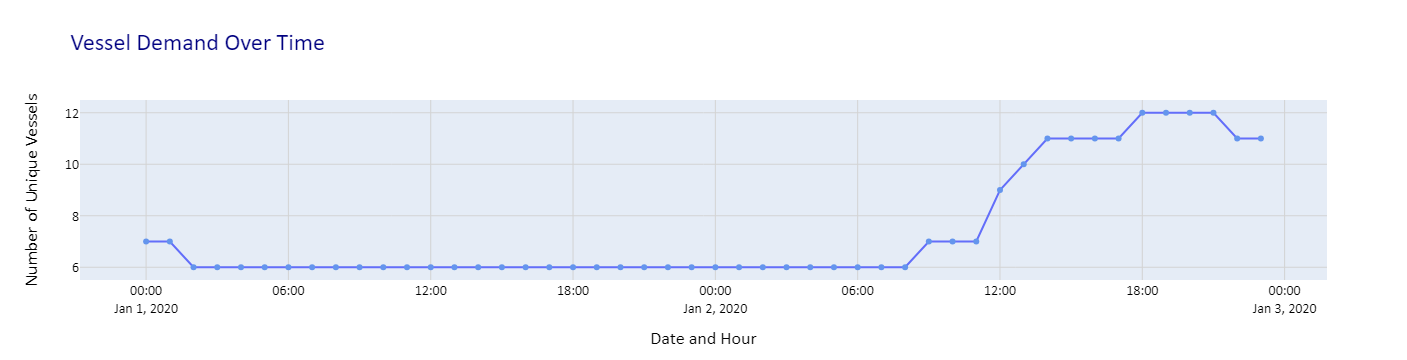

In [70]:
line_plot(vessel_df)

## Plotting all the Ports coordinates to decide on the bounding box boundary line (appropriate height and width)

In [54]:
updated_pud = pd.read_sql('select * from updated_pud ', connection)
height=0.0485
width=0.0966
lgb_lon=updated_pud.loc[updated_pud['un_locode']=='US LGB','longitude'].values[0]
lgb_lat=updated_pud.loc[updated_pud['un_locode']=='US LGB','latitude'].values[0]
# Calculate bounding box
min_lat, max_lat, min_lng, max_lng = calculate_bounding_box(lgb_lat, lgb_lon, height, width)
# Initialize the map with the first coordinate
gmap = gmplot.GoogleMapPlotter(lgb_lat, lgb_lon, 19)
gmap.marker(lgb_lat, lgb_lon, color='darkgreen',label='US LGB')

# Plot the bounding box
bounding_box_lats = [min_lat, min_lat, max_lat, max_lat, min_lat]
bounding_box_lngs = [min_lng, max_lng, max_lng, min_lng, min_lng]
gmap.plot(bounding_box_lats, bounding_box_lngs, 'cornflowerblue',edge_width=3, edge_alpha=0.6, edge_style='dotted')

# Add markers to the map for each point
for index, row in updated_pud.iterrows():
    if row['harbor_use']=='Cargo':
        gmap.marker(row['latitude'], row['longitude'], color='red') 
    elif row['harbor_use']=='Ferry':
        gmap.marker(row['latitude'], row['longitude'], color='pink') 
    elif row['harbor_use']=='Fishing':
        gmap.marker(row['latitude'], row['longitude'], color='blue') 
    elif row['harbor_use']=='Military':
        gmap.marker(row['latitude'], row['longitude'], color='yellow') 
    else :
        gmap.marker(row['latitude'], row['longitude'], color='black')
        
# Save the map
gmap.draw("neighbouring_ports.html")

## Valdating over 3rd Jan to 4th Jan'20 and 4th July to 5th July 2020.

In [63]:
def vessels_at_port(port_code):
    #Defining the bounding box to sample down the data.
    height=0.0485
    width=0.0966
    #Reading Port coordinates file and fetching longitude and latitude
    updated_pud = pd.read_sql('SELECT * FROM updated_pud', connection)
    
    # Read longitude and latitude points from AIS file of only cargo vessels
    cargo_vessels = pd.read_sql('SELECT * FROM cargo_vessels_ais_val', connection)
    
    subset_cargo_vessels=bounding_box_plot(port_code,height,width,ports_data=updated_pud,vessels_data=cargo_vessels)
    #the Number of unique cargo vessels within the port of Long Beach, throughout the day
    #Convert basedatetime to date time format
    subset_cargo_vessels['basedatetime'] = pd.to_datetime(subset_cargo_vessels['basedatetime'])
    # Combine date and hour into a single datetime column
    subset_cargo_vessels['date_hour_combined'] = subset_cargo_vessels.apply(lambda row: pd.Timestamp(row['basedatetime'].date()) + pd.Timedelta(hours=row['basedatetime'].hour), axis=1)

    vessel_df=subset_cargo_vessels.groupby('date_hour_combined').agg(distinct_vessels=('vesselname', 'nunique'))
    vessel_df.reset_index(inplace=True)
    return(vessel_df)


In [76]:
vessel_val_df=vessels_at_port('US LGB')

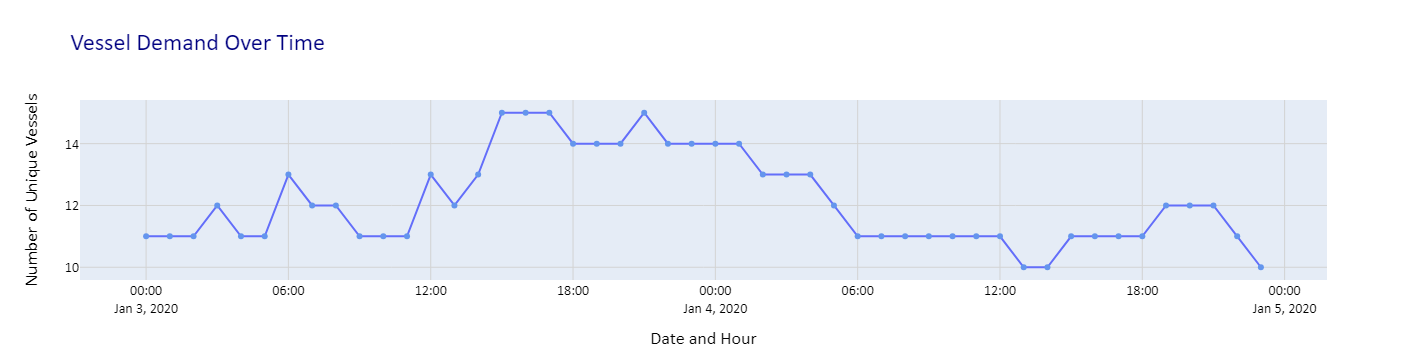

In [77]:
## Plotting 3rd and 4th Jan 2020 data
line_plot(vessel_val_df.loc[vessel_val_df['date_hour_combined']<'2020-07-01 00:00:00',:])

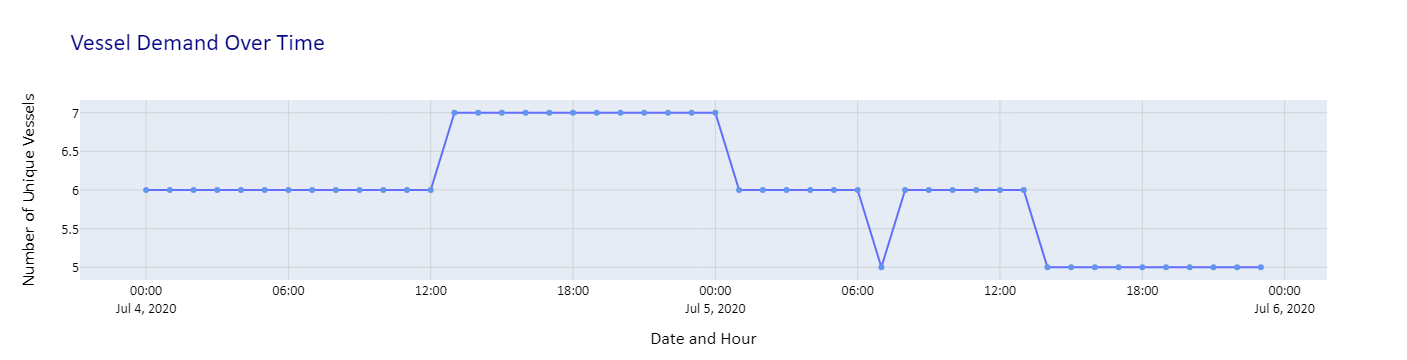

In [78]:
## Plotting 4th July 2020 onwards data (till 7th July)
line_plot(vessel_val_df.loc[vessel_val_df['date_hour_combined']>'2020-07-01 00:00:00',:])